In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path += ['../']

In [3]:
from ToyTrajectoryNet.utils import generate_steps, set_seeds, config_criterion
from ToyTrajectoryNet.models import make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train_ae, training_regimen
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.geo import setup_distance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data



import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time
import pickle

import phate
import scprep


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

# Preprocess Data

In [4]:
# https://nbviewer.org/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb

# Load Data
download_path='../data/'
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


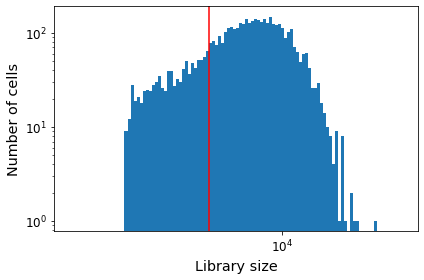

In [5]:
scprep.plot.plot_library_size(T1, percentile=20)
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

In [6]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),...,ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='Gene expression', ylabel='Number of cells'>

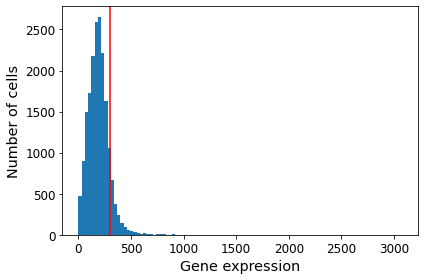

In [7]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

In [8]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [9]:
print('Data Shape: ', EBT_counts.shape)
EBT_counts.head()

Data Shape:  (16821, 17845)


,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.022861,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.112210,0.0,0.0,0.0,0.0,0.0,1.11221,0.0,0.0
AAAGATCTCTGCTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.352958,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAAGATCTGGTACT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


# Phate Visualization

In [10]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 28.96 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.01 seconds.
    Calculating affinities...
    Calculated affinities in 0.87 seconds.
  Calculated graph and diffusion operator in 41.34 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.16 seconds.
  Calculated landmark operator in 9.76 seconds.
  Calculating optimal t...
    Automatically selected t = 39
  Calculated optimal t in 2.22 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.07 seconds.
Calculated PHATE in 59.58 seconds.


/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

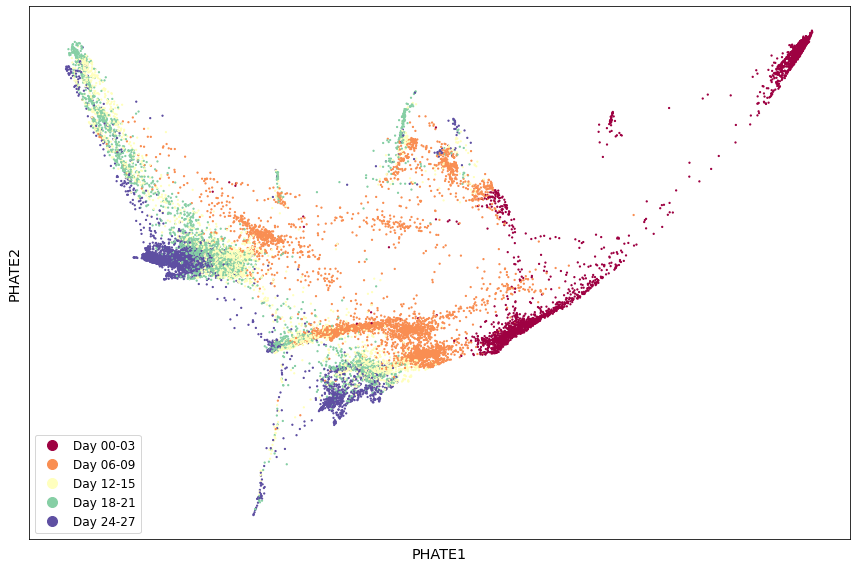

In [11]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# PCA Visulization

In [12]:
import sklearn.decomposition # PCA
import time

start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
Y_pca = pca_operator.fit_transform(np.array(EBT_counts))
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

Embedded PCA in 21.41 seconds.


/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:title={'center':'PCA'}, xlabel='PC1', ylabel='PC2'>

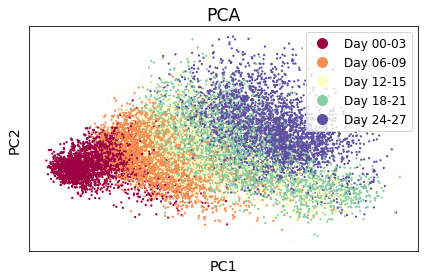

In [13]:
scprep.plot.scatter2d(Y_pca, label_prefix="PC", title="PCA",
                      c=sample_labels, ticks=False, cmap='Spectral')

In [14]:
Y_pca.shape

(16821, 2)

In [15]:
# Inverse Transform
recon_pca = pca_operator.inverse_transform(Y_pca)

In [16]:
recon_pca.shape

(16821, 17845)

In [17]:
Y_pca = pca_operator.fit_transform(np.array(recon_pca))
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

Embedded PCA in 40.54 seconds.


/Users/danqiliao/opt/miniconda3/envs/cos429/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:title={'center':'PCA'}, xlabel='PC1', ylabel='PC2'>

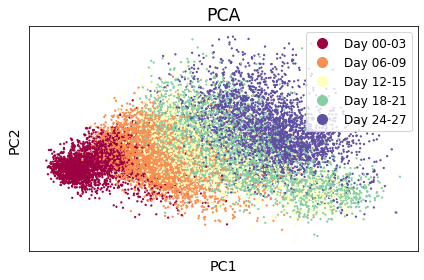

In [18]:
scprep.plot.scatter2d(Y_pca, label_prefix="PC", title="PCA",
                      c=sample_labels, ticks=False, cmap='Spectral')

# Save preprocessed data

In [19]:
EBT_counts.shape

(16821, 17845)

In [21]:
raw_data_path = '../data/prep-EB-gene-space.csv'
EBT_counts.to_csv(raw_data_path)

In [22]:
EBT_counts.shape

(16821, 17845)

In [23]:
EBT_counts.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.022861,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.112210,0.0,0.0,0.0,0.0,0.0,1.11221,0.0,0.0
AAAGATCTCTGCTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.352958,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AAAGATCTGGTACT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [24]:
# Try not keep index?
EBT_counts.to_csv('../data/test-prep-EB-gene-space.csv', index=False)

In [25]:
# Test
raw_data_path = '../data/test-prep-EB-gene-space.csv'
test_data = pd.read_csv(raw_data_path)

In [26]:
test_data.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.022861,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.112210,0.0,0.0,0.0,0.0,0.0,1.11221,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.352958,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [27]:
test_data.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.022861,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.112210,0.0,0.0,0.0,0.0,0.0,1.11221,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.352958,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
